# **BUSINNESS PROBLEM**

Predicting the tweets posted by Twitter users as positive, negative and neutral in terms of the sentiment they carry.

# **DATA SET STORY**

'tweet_labeled.csv' contains tweets posted on Twitter in 2022, the dates the tweets were posted, and labels with -1, 0, and 1 based on the sentiment in the tweets. 'tweets_21.csv' includes tweets from 2021.

# **FEATURE ENGİNEERİNG**

First, let's include the libraries we need and set some display options using the pandas library.


In [5]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [7]:
filterwarnings('ignore')

Let's start our process by reading the 'labeled_tweets.csv' file

In [8]:
df = pd.read_csv("tweets_labeled.csv")

Let's examine the data.

In [9]:
df.columns

Index(['tweet_id', 'tweet', 'date', 'label'], dtype='object')

In [10]:
df.shape

(12960, 4)

In [11]:
df.head()

,tweet_id,tweet,date,label
0,1606767075984375808,Berk Ali (kedim) seni çok özledim. Ölmek için ...,2022-12-24 21:41:37+00:00,1
1,1537178207677448193,"Yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-15 21:00:18+00:00,1
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-13 21:21:36+00:00,1
3,1495413883166760960,"Öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 15:03:47+00:00,1
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 20:22:32+00:00,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  12960 non-null  int64 
 1   tweet     12959 non-null  object
 2   date      12960 non-null  object
 3   label     12960 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 405.1+ KB


In [13]:
df.isnull().sum()

,0
tweet_id,0
tweet,1
date,0
label,0


As you can see, there is 1 missing value in our data set. Let's remove this missing value from the data set.

In [14]:
df = df.dropna()

Now let's change the 'date' variable so that the time zone is GMT+03:00.

In [15]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
if df['date'].dt.tz is None:
  df['date'] = df['date'].dt.tz_localize('GMT')
df['date'] = df['date'].dt.tz_convert('Etc/GMT-3')

Now let's create the variables 'season', 'day' and '4_intervals'.

In [16]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [17]:
df['season'] = df['date'].apply(get_season)

In [18]:
df["day"] = [date.strftime('%A') for date in df["date"]]

In [19]:
def get_time_period(date):
    hour = date.hour
    if 22 <= hour or hour < 2:
        return '22:00-02:00'
    elif 2 <= hour < 6:
        return '02:00-06:00'
    elif 6 <= hour < 10:
        return '06:00-10:00'
    elif 10 <= hour < 14:
        return '10:00-14:00'
    elif 14 <= hour < 18:
        return '14:00-18:00'
    else:
        return '18:00-22:00'

In [20]:
df['4_intervals'] = df['date'].apply(get_time_period)

In [21]:
print(df[['date', 'season', 'day', '4_intervals']].head())

                       date  season       day  4_intervals
0 2022-12-25 00:41:37+03:00  Winter    Sunday  22:00-02:00
1 2022-06-16 00:00:18+03:00  Summer  Thursday  22:00-02:00
2 2022-06-14 00:21:36+03:00  Summer   Tuesday  22:00-02:00
3 2022-02-20 18:03:47+03:00  Winter    Sunday  18:00-22:00
4 2022-02-06 23:22:32+03:00  Winter    Sunday  22:00-02:00


Now let's change the 'label variable' so that 1=positive, -1=negative and 0=neutral.

In [22]:
df['label'] = df['label'].map({1: 'positive', -1: 'negative', 0: 'neutral'})

Now let's capture the numerical and categorical variables.

In [23]:
df.dtypes

,0
tweet_id,int64
tweet,object
date,"datetime64[ns, Etc/GMT-3]"
label,object
season,object
day,object
4_intervals,object


In [24]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numeric_features = df.select_dtypes(include=['number']).columns.tolist()

Now let's examine the target variable

In [25]:
df['label'].value_counts()

,count
label,
neutral,8448
negative,2904
positive,1607


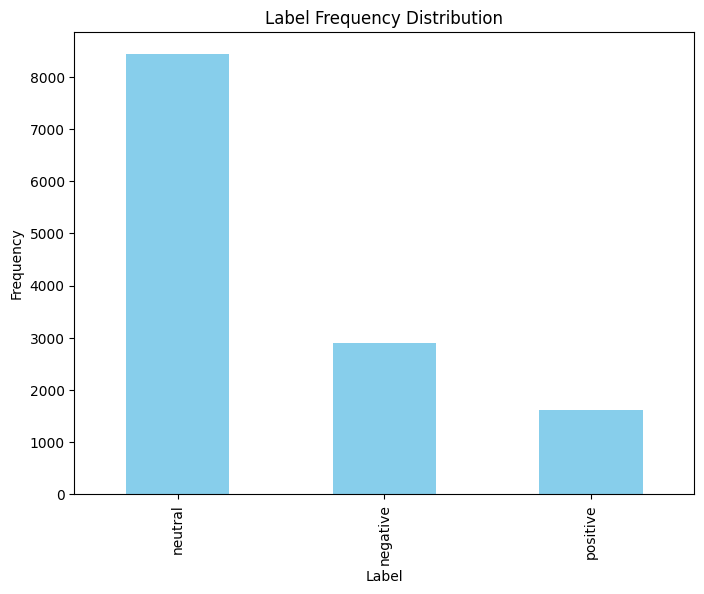

In [26]:
plt.figure(figsize=(8, 6))
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Label Frequency Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [27]:
100*df["label"].value_counts()/len(df)

,count
label,
neutral,65.190
negative,22.409
positive,12.401


In [28]:
import plotly.graph_objects as go
colors = ['green', 'orange', 'blue']
labels = ['positive','negative', 'neutral']
values = df['label'].value_counts()/df['label'].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=40,
                  marker=dict(colors=colors, line=dict(color='black', width=5)))
fig.update_layout(
    title_text="label")
fig.show()

# **DATA PREPARATION AND LOGISTIC REGRESSION**

In this section, we will prepare the data and make a prediction by establishing the logistic regression model. First, let's convert the 'tweet' variable to lowercase.

In [29]:
df['tweet'] = df['tweet'].str.lower()

Now let's express the 'label' variable numerically by applying the label encoding process.

In [30]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

Now let's apply the TF-IDF method using the 'tweet' variable and create the matrix.

**Information:** The TF-IDF method is a normalized, standardized word vector creation method to eliminate some biases that the 'count vector' method may reveal. A standardization process is performed focusing on the frequency of occurrence of words in documents and the frequency of occurrence of words in the entire corupus.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tweet'])

In [32]:
print("TF-IDF Matrix Size:", tfidf_matrix.shape)

TF-IDF Matrix Size: (12959, 45364)


In [33]:
feature_names = tfidf_vectorizer.get_feature_names_out()
print("First 10 Words:", feature_names[:10])
print("TF-IDF Values ​​for First Document:", tfidf_matrix[0].toarray()[0][:10])

First 10 Words: ['00' '000' '0000' '00001' '0001' '000800' '001000' '0022' '0057' '0099']
TF-IDF Values ​​for First Document: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
# Creating a sample TF-IDF matrix by taking the first 100 words and the first 10 documents
tfidf_sample = tfidf_matrix[:10, :100].toarray()
feature_names_sample = tfidf_vectorizer.get_feature_names_out()[:100]

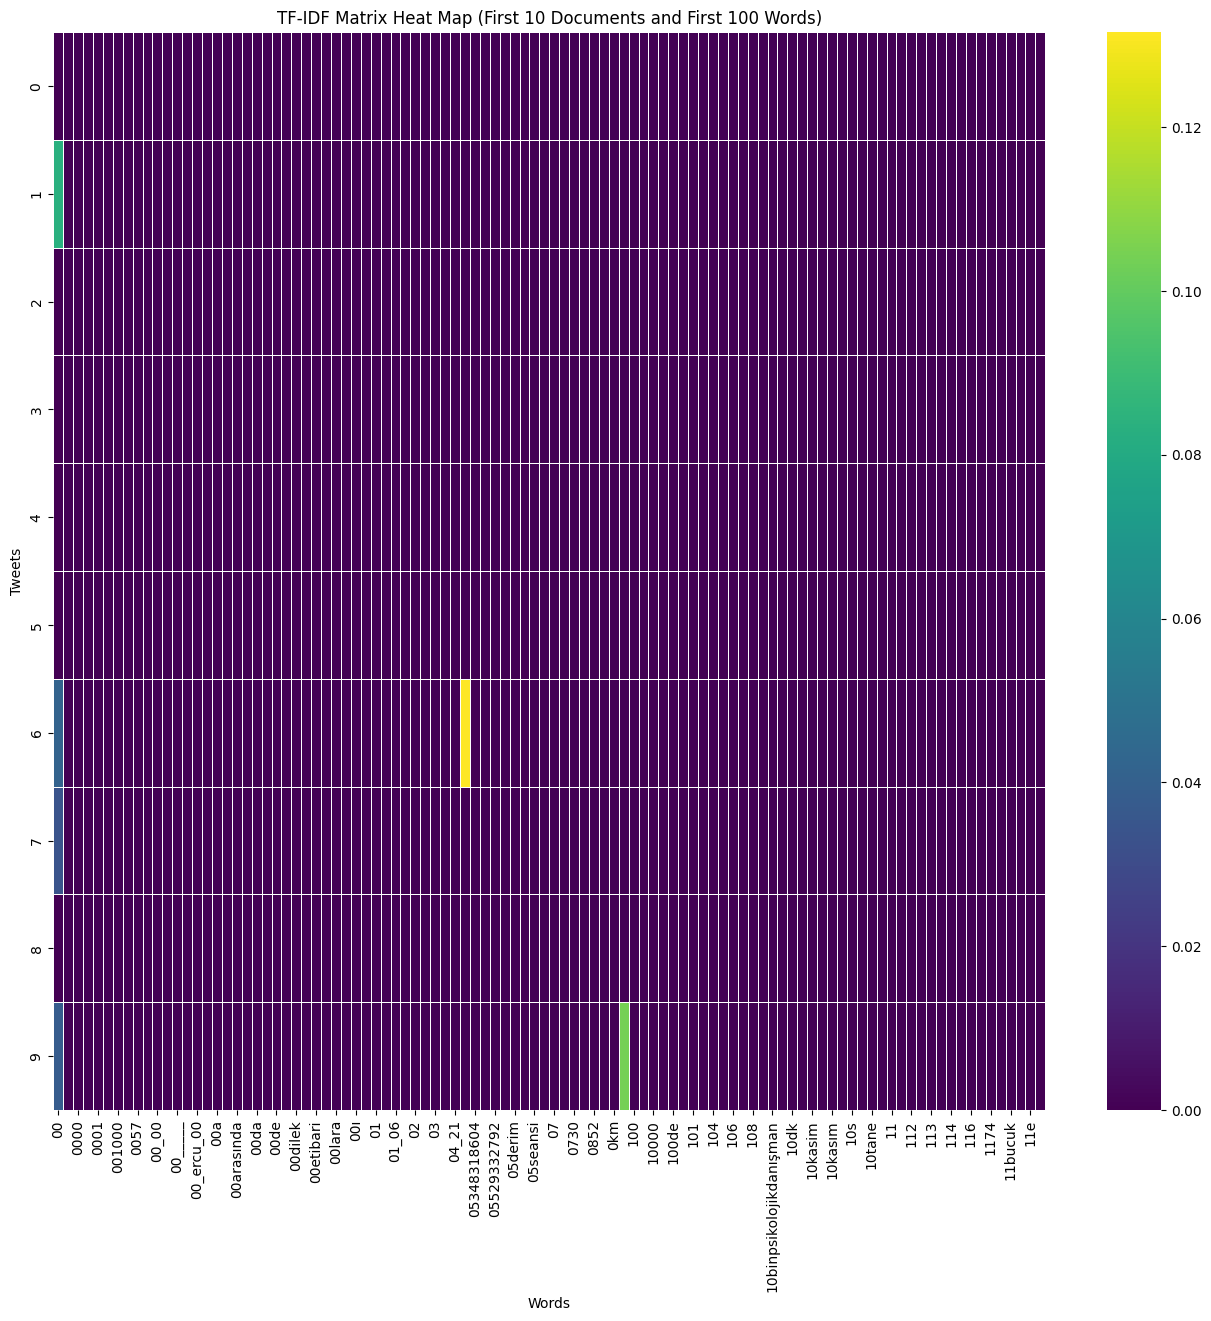

In [35]:
df_tfidf = pd.DataFrame(tfidf_sample, columns=feature_names_sample)

# Heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(df_tfidf, cmap='viridis', linewidths=.5)
plt.title('TF-IDF Matrix Heat Map (First 10 Documents and First 100 Words)')
plt.xlabel('Words')
plt.ylabel('Tweets')
plt.show()


Now let's set up the logistic regression model using the TF-IDF matrix and the 'label' target variable and evaluate the accuracy.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [37]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=5)
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2}")

Model Accuracy: 0.69


Now let's read the file named 'tweet_21.csv' and fix the variable types. Then convert them to lower case.

In [38]:
df2 = pd.read_csv("tweets_21.csv")

In [39]:
df2.dtypes

,0
tweet_id,int64
tweet,object
date,object


In [40]:
df2['date'] = pd.to_datetime(df2['date'], errors='coerce')

In [41]:
df2['tweet'] = df2['tweet'].str.lower()

# **PREDICTION OF SENTIMENT IN TWEETS**

Let's perform the prediction process for tweets from 2021 using 'tf_idfvectorizer' and logistic regression model. Let's create a variable named 'label' for the prediction results we obtained and save the predictions.

In [42]:
X_tfidf_21 = tfidf_vectorizer.transform(df2['tweet'])
df2['label'] = model.predict(X_tfidf_21)

In [43]:
df2.tail(35)

,tweet_id,tweet,date,label
13237,1476606051386544131,finallere çalışacağım aklıma gelince tüm yaşam...,2021-12-30 20:28:11,1
13238,1476606101646888965,"minibusu kacirdim, eve gecikicem (19.00) diye ...",2021-12-30 20:28:23,1
13239,1476610889549766667,biz mutlu olana kadar \n hayat \nbitece...,2021-12-30 20:47:24,0
13240,1476616089677312004,bu sene de 00:00 seni seviyorum mesajı gelmice...,2021-12-30 21:08:04,1
13241,1476616337208315910,özel günleri önemsiyorum. ailem için de hep öy...,2021-12-30 21:09:03,1
13242,1476623459451121666,yarın 2 tane musevi bayanla birlikteyiz.. 19:0...,2021-12-30 21:37:21,1
13243,1476625360364130305,yarın 00.00 da kimseye o istediği mesaj gelmey...,2021-12-30 21:44:54,1
13244,1476628814105124867,ayy herkes yeni yıl planı yapıyor ne değişecek...,2021-12-30 21:58:38,1
13245,1476631875191980046,"düşünsenize yeni yılda saat 00:00'da ""seni sev...",2021-12-30 22:10:48,2
13246,1476634544002457608,"yeni yıla girerken 00.00 da şöyle bir mesaj ""h...",2021-12-30 22:21:24,1


The project ends here. A pipeline.py file has been created for the processes here. The processes have been functionalized and automated.